In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

## Load data & parameters

In [2]:
adata_epi_chen      = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)
chen_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.CRC.woSD.run_meta.organized.tsv', sep='\t',)

dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_epi_chen.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_epi_chen.obs['PatientID'] ]

In [13]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.labeled.h5ad')

In [14]:
adata.obs.head(2)

,doublet_score,predicted_doublet,SampleID,PatientID,BiopsySite,Accession,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,...,Author_CellType_lvl_1,Author_CellType_lvl_2,n_genes,AvgSTRDiff,StdSTRDiff,NumSTRLoci,MSI,Response,Manual_CellType_lvl_1,Manual_CellType_lvl_2
AAACCTGAGAATTCCC-1,0.013780,False,P04-N-I,P04,Normal,HRR1372976,1197,7.088409,2594.0,7.861342,...,T,c20_CD8_Tem_GZMK,1197,0.0,0.0,0,MSI,CR,T,CD8+ T
AAACCTGAGCTAGGCA-1,0.021638,False,P04-N-I,P04,Normal,HRR1372976,1206,7.095893,3195.0,8.069655,...,B,c40_NaiveB_IGHD,1206,0.0,0.0,0,MSI,CR,B,Naive B


In [3]:
adata_epi_chen.obs['MSI_score'] = -1 * adata_epi_chen.obs['AvgSTRDiff'] * adata_epi_chen.obs['StdSTRDiff']

In [9]:
u, s = np.mean(adata_epi_chen.obs['AvgSTRDiff']), np.std(adata_epi_chen.obs['AvgSTRDiff'])
adata_epi_chen.obs['Scaled_AvgSTRDiff'] = [ (AvgSTRDiff-u)/s for AvgSTRDiff in adata_epi_chen.obs['AvgSTRDiff'] ]

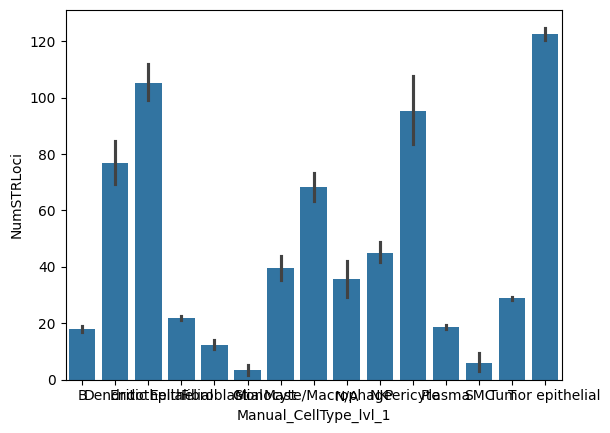

In [17]:
ax = sns.barplot(data=adata.obs, x='Manual_CellType_lvl_1', y='NumSTRLoci')
plt.show()

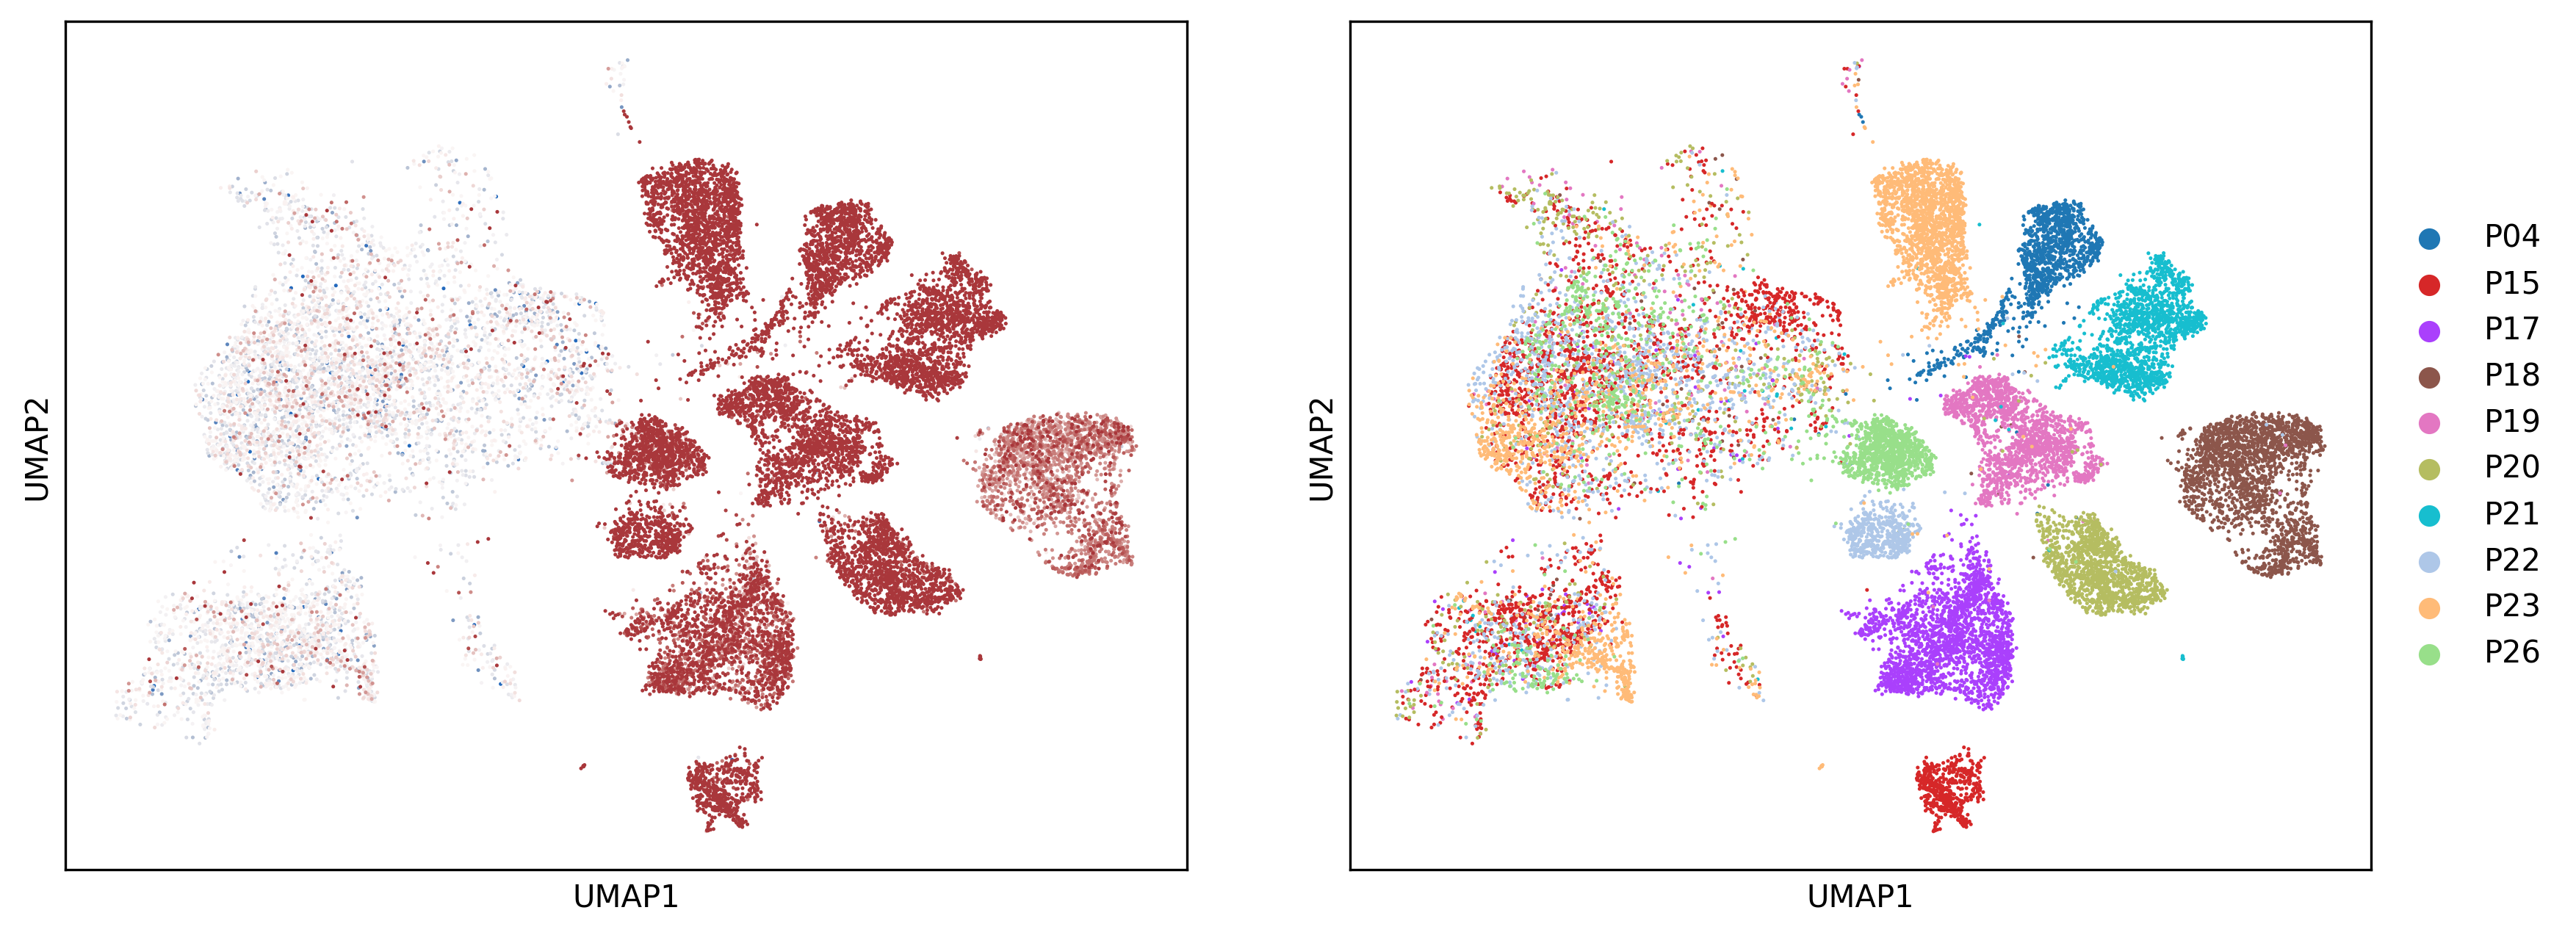

In [25]:
with plt.rc_context({'figure.figsize' : (6, 5), 'figure.dpi' : 300}):
    sc.pl.umap(adata_epi_chen[adata_epi_chen.obs['NumSTRLoci']!=0], color=['MSI_score', 'PatientID'], vmin=-2, vmax=2, cmap='vlag', title=['', ''], colorbar_loc=None, frameon=True, )

## Analysis

In [26]:
AlleleTable = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NanoMnT.AlleleTable.tsv.gz', sep='\t', )

/tmp/ipykernel_211369/1483400063.py:1: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  AlleleTable = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NanoMnT.AlleleTable.tsv.gz', sep='\t', )


In [92]:
AlleleTable.shape

(19985310, 19)

In [27]:
AlleleTable.dropna(inplace=True)
AlleleTable = AlleleTable[AlleleTable['SampleID'].isin(adata_epi_chen.obs['SampleID'])].copy()

In [28]:
AlleleTable.shape # (3927813, 19)

(3927813, 19)

In [29]:
dict_SampleID_to_PatientID = dict()
for tup in chen_metadata.itertuples():
    dict_SampleID_to_PatientID[tup.SampleID] = tup.PatientID
AlleleTable['PatientID'] = [ dict_SampleID_to_PatientID[SID] for SID in AlleleTable['SampleID'] ]

In [30]:
STRProfileByLength = list()
for PatientID, edf in AlleleTable.groupby("PatientID"):
    for isTumor, edf2 in edf.groupby("isTumor"):
        for reference_STR_allele, edf3 in edf2.groupby("reference_STR_allele"):
            STRProfileByLength.append( [PatientID, reference_STR_allele, isTumor, np.mean(edf3['diff'].dropna()), np.std(edf3['diff'].dropna()), len(edf3.dropna()), ] )
STRProfileByLength = pd.DataFrame(STRProfileByLength, columns=['PatientID', 'reference_STR_allele', 'isTumor', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci'])
STRProfileByLength['MSI_score'] = -1 * STRProfileByLength['AvgSTRDiff'] * STRProfileByLength['StdSTRDiff']

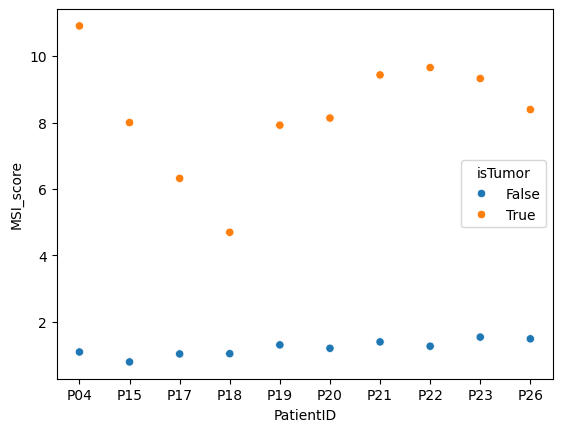

In [86]:
STRProfileByLength2 = list()
for PatientID, edf in STRProfileByLength.groupby('PatientID', observed=True):
    for isTumor, edf2 in edf.groupby('isTumor', observed=True):
        # if isTumor==False: continue 
        STRProfileByLength2.append( [PatientID, isTumor, np.mean(edf2['MSI_score'])] )
STRProfileByLength2 = pd.DataFrame(STRProfileByLength2, columns=['PatientID', 'isTumor', 'MSI_score'])
sns.scatterplot(data=STRProfileByLength2, x='PatientID', y='MSI_score', hue='isTumor') 
plt.show()

## MSI intensity ∝ ICI response

In [87]:
dict_PatientID_to_Response = { PID : edf.iloc[0].Response for PID, edf in adata_epi_chen.obs.groupby('PatientID', observed=True,) }
STRProfileByLength2['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in STRProfileByLength2['PatientID'] ]
STRProfileByLength2['Response'] = [ dict_PatientID_to_Response[PID] for PID in STRProfileByLength2['PatientID'] ]

/tmp/ipykernel_211369/1964797600.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=STRProfileByLength2[STRProfileByLength2['isTumor']==True], x='Response', y='MSI_score',  palette=['cornflowerblue', 'goldenrod'], whis=(0, 100) )


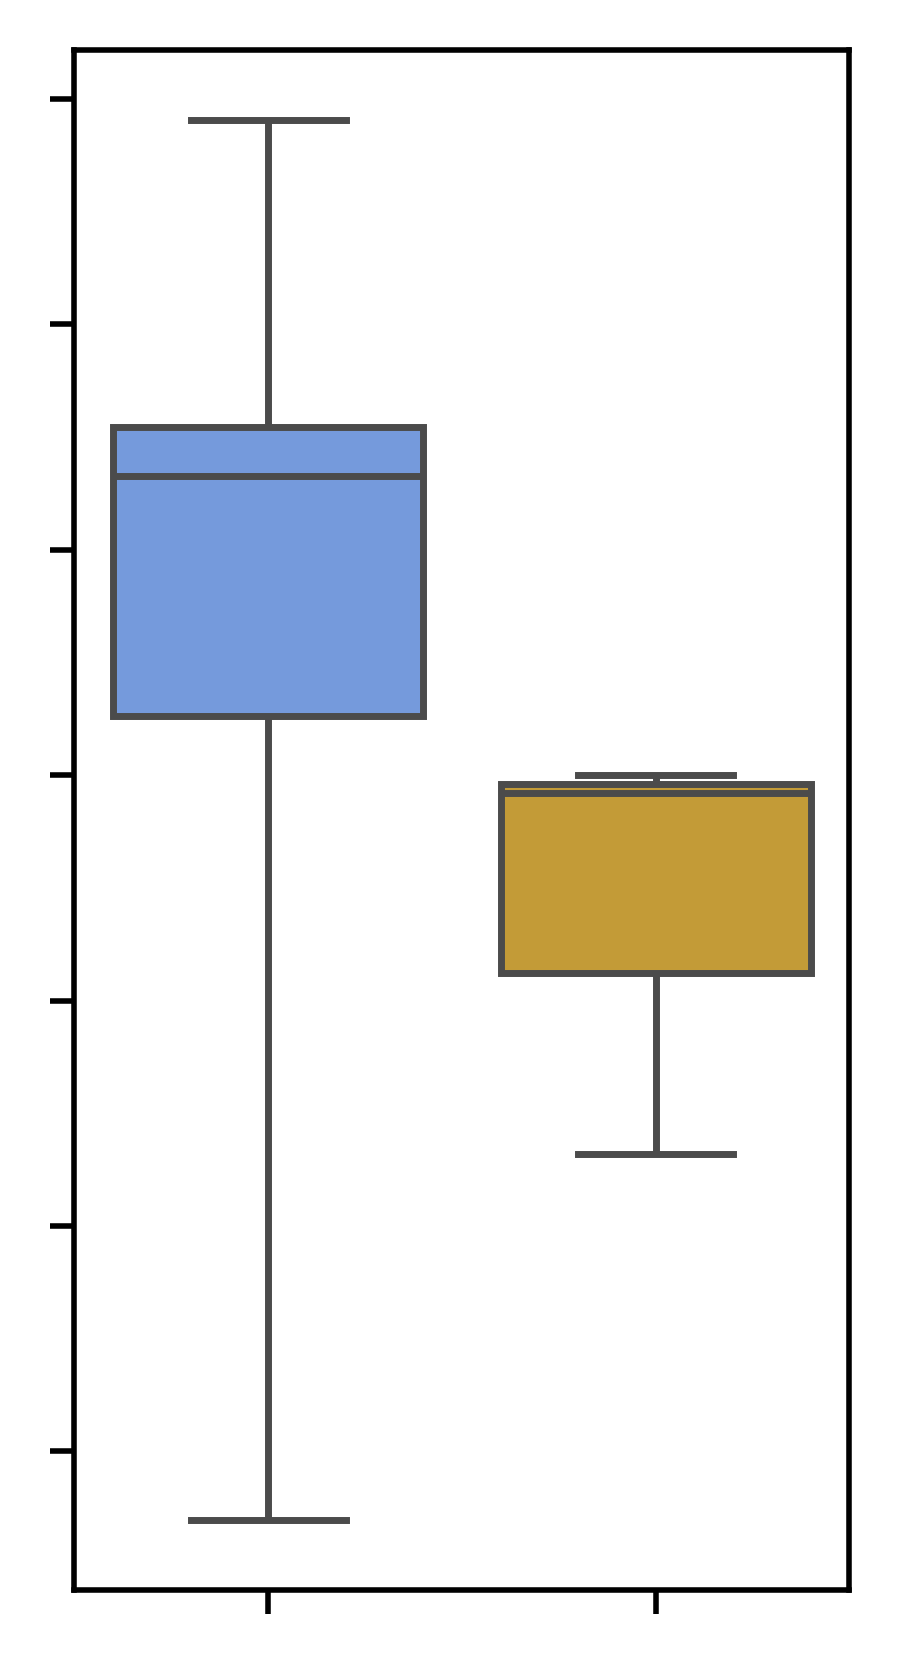

In [130]:
plt.figure(figsize=(2, 4), dpi=500)
ax = sns.boxplot(data=STRProfileByLength2[STRProfileByLength2['isTumor']==True], x='Response', y='MSI_score',  palette=['cornflowerblue', 'goldenrod'], whis=(0, 100) )
# ax = sns.stripplot(data=STRProfileByLength2[STRProfileByLength2['isTumor']==True], x='Response', y='MSI_score', color='black',
#                    jitter=0, alpha=0.5,)
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
plt.show()

## MSI intensity ∝ Tumor regression ratio

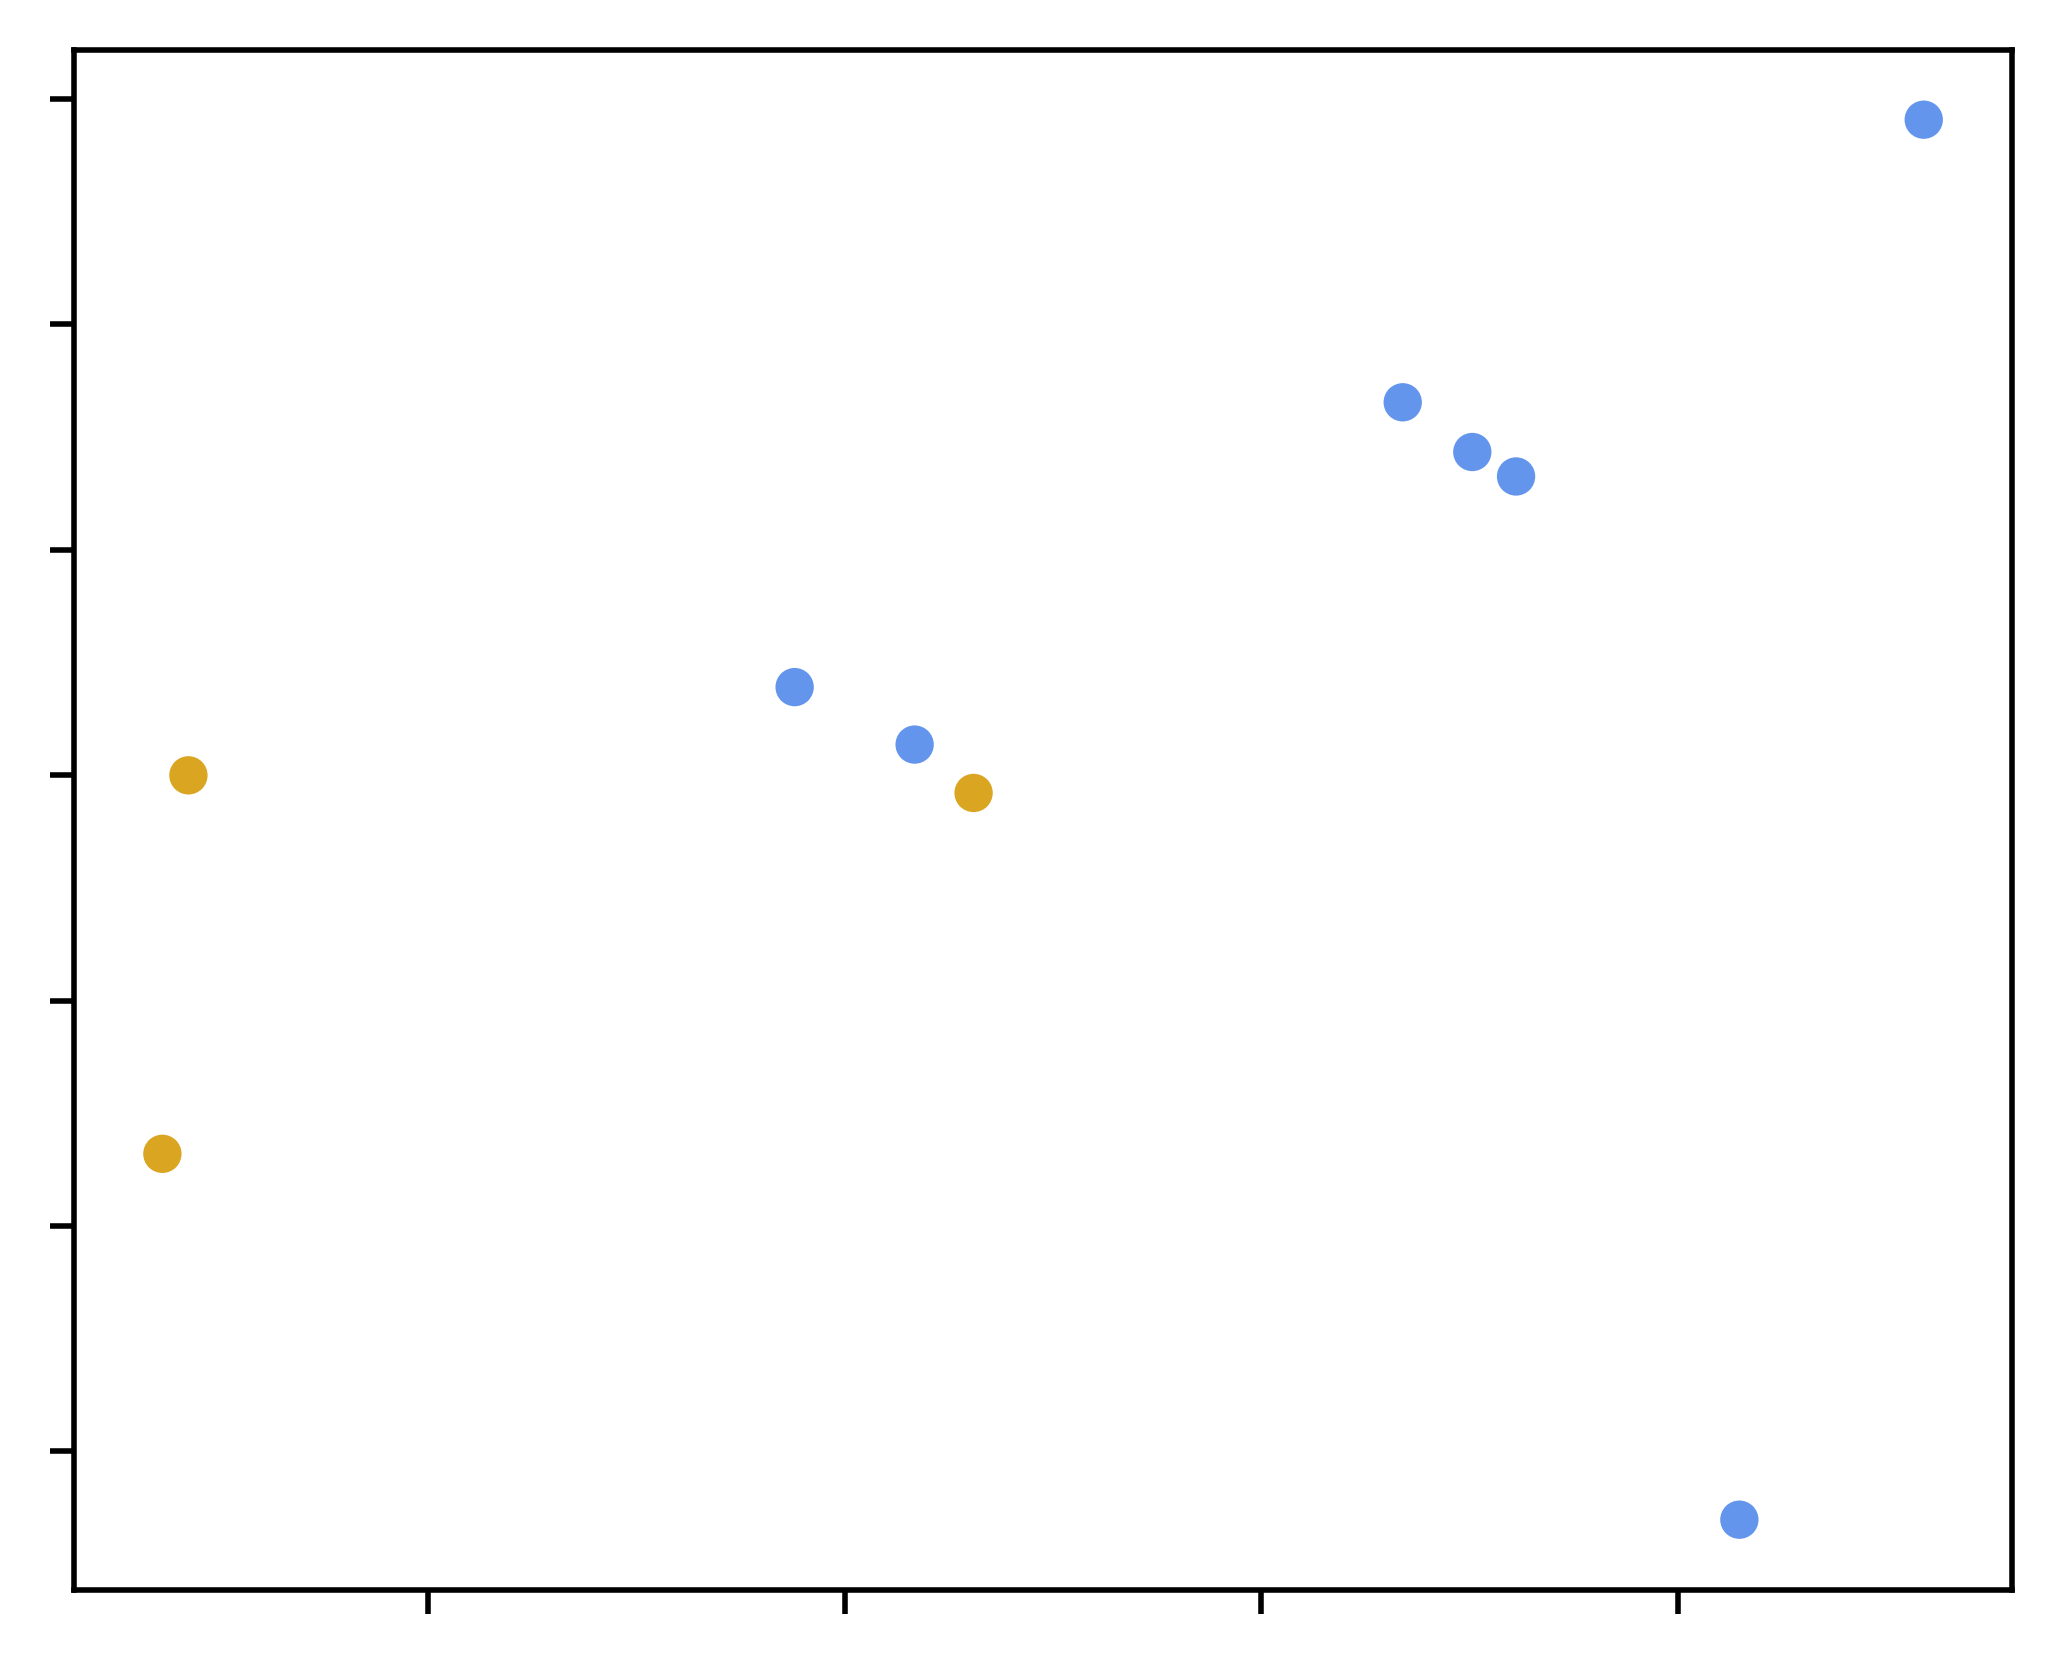

In [118]:
plt.figure(figsize=(5, 4), dpi=500)
ax = sns.scatterplot(data=STRProfileByLength2[(STRProfileByLength2['isTumor']==True)].sort_values('MSI_score'), 
                 x='TumorRegressionRatio', y='MSI_score', 
                 hue='Response', palette=['cornflowerblue', 'goldenrod'],
                 legend=None,)
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
plt.show()

In [116]:
r, pval = stats.pearsonr( STRProfileByLength2[(STRProfileByLength2['isTumor']==True)]['MSI_score'],
                         STRProfileByLength2[(STRProfileByLength2['isTumor']==True)]['TumorRegressionRatio'] )
print(round(r, 3), round(pval, 3))

r, pval = stats.pearsonr( STRProfileByLength2[(STRProfileByLength2['isTumor']==True) & (STRProfileByLength2['PatientID']!='P18')]['MSI_score'],
                         STRProfileByLength2[(STRProfileByLength2['isTumor']==True) & (STRProfileByLength2['PatientID']!='P18')]['TumorRegressionRatio'] )
print(round(r, 3), round(pval, 3))


0.339 0.338
0.913 0.001


/tmp/ipykernel_211369/3823162024.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=STRProfileByLength2.sort_values('MSI_score'), x='TumorRegressionRatio', y='MSI_score',
/tmp/ipykernel_211369/3823162024.py:2: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=STRProfileByLength2.sort_values('MSI_score'), x='TumorRegressionRatio', y='MSI_score',


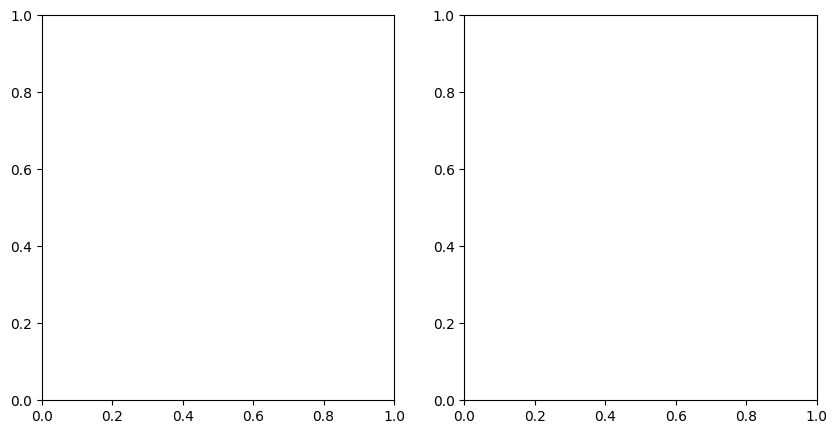

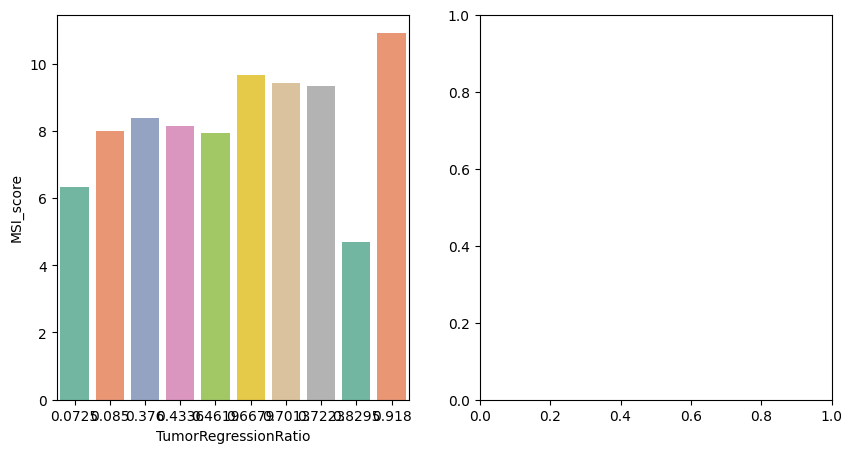

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(data=STRProfileByLength2.sort_values('MSI_score'), x='PatientID', y='MSI_score', 
            palette=sns.color_palette("Set2",),
                ax=axes[0])
plt.show()

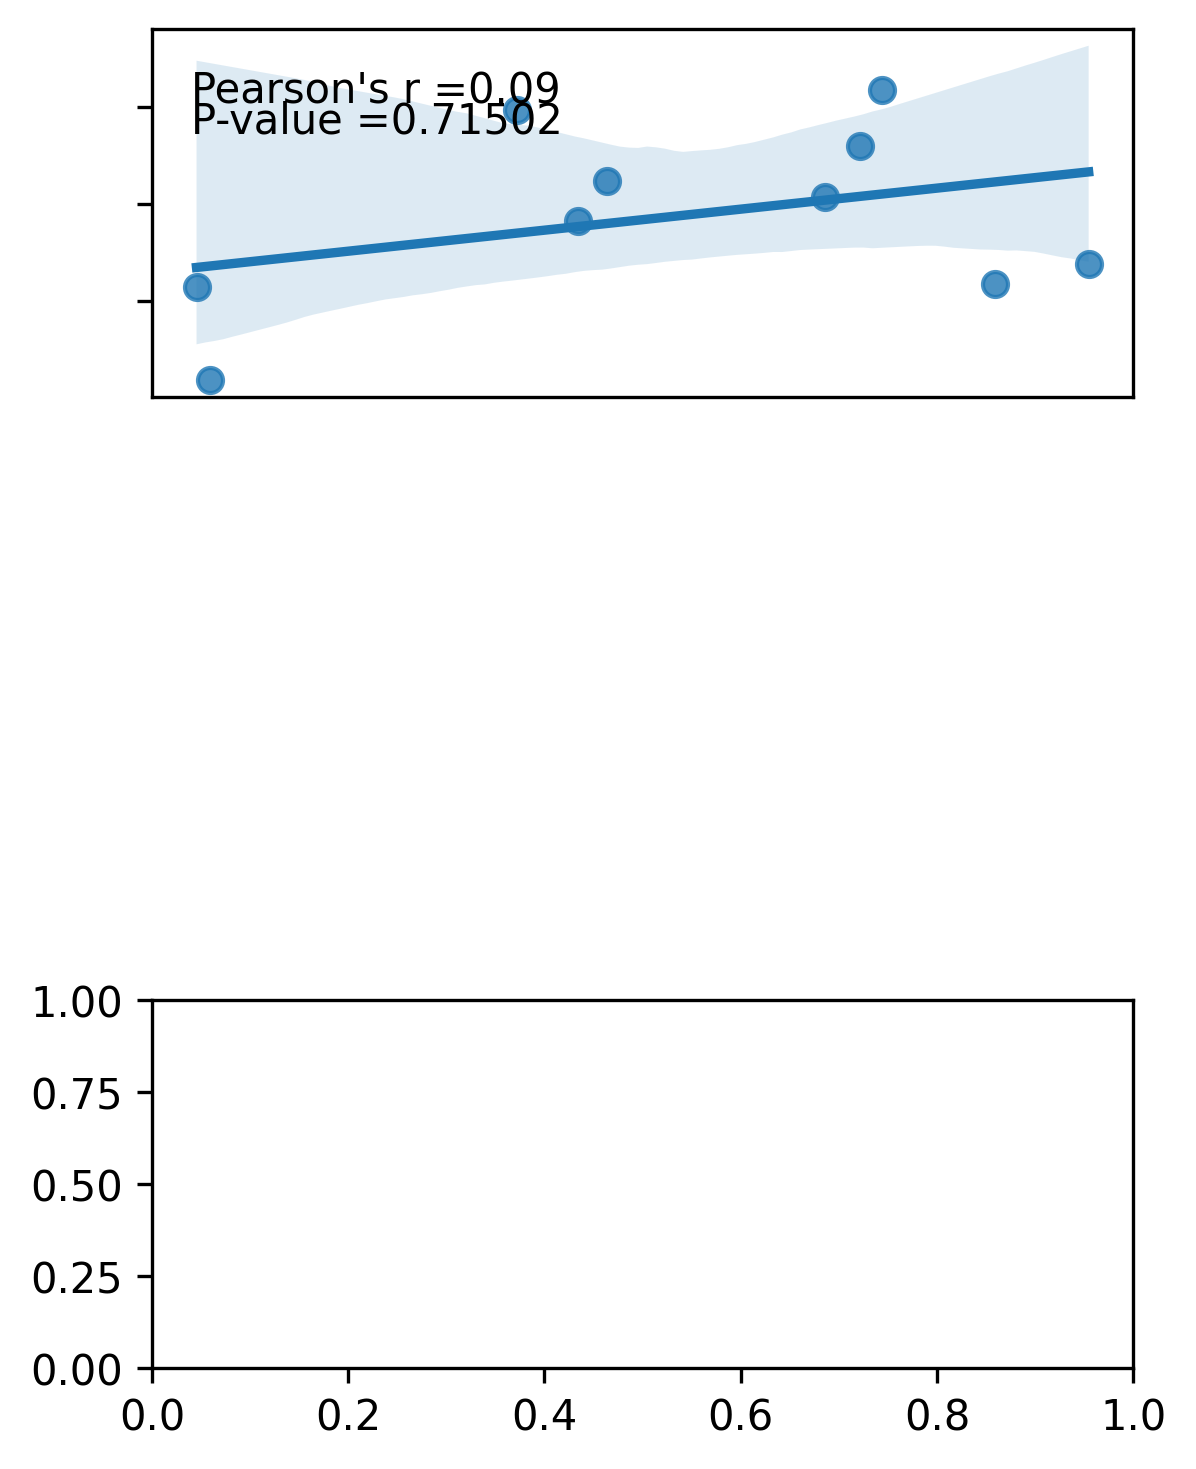

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(4, 5), dpi=300, sharex=False, sharey=False)
ax = sns.regplot(data=STRProfileByLength2[(STRProfileByLength2['isTumor']==False)].sort_values('MSI_score'), 
                 x='TumorRegressionRatio', y='MSI_score', 
                 # hue='PatientID', 
                 # legend=None, 
                 ax=axes[0])
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, .75))
ax.set_ylabel('');
ax.set_xlabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.tick_params(bottom=False,)
# r, pval = stats.pearsonr( MSIintensityICIResponse['Scaled_AvgMSLengths'], MSIintensityICIResponse['TumorRegressionRatio'] )
# plt.text(.04, .8, "Pearson's r ={:.5f}".format(r), transform=ax.transAxes)
# plt.text(.04, .7, "P-value ={:.5f}".format(pval), transform=ax.transAxes)

r, pval = stats.pearsonr( STRProfileByLength2['MSI_score'], STRProfileByLength2['TumorRegressionRatio'] )
plt.text(.04, .8, "Pearson's r ={:.2f}".format(r), transform=ax.transAxes)
plt.text(.04, .72, "P-value ={:.5f}".format(pval), transform=ax.transAxes)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, .75))
ax.set_ylabel('');
ax.set_xlabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
plt.tight_layout();
plt.show()

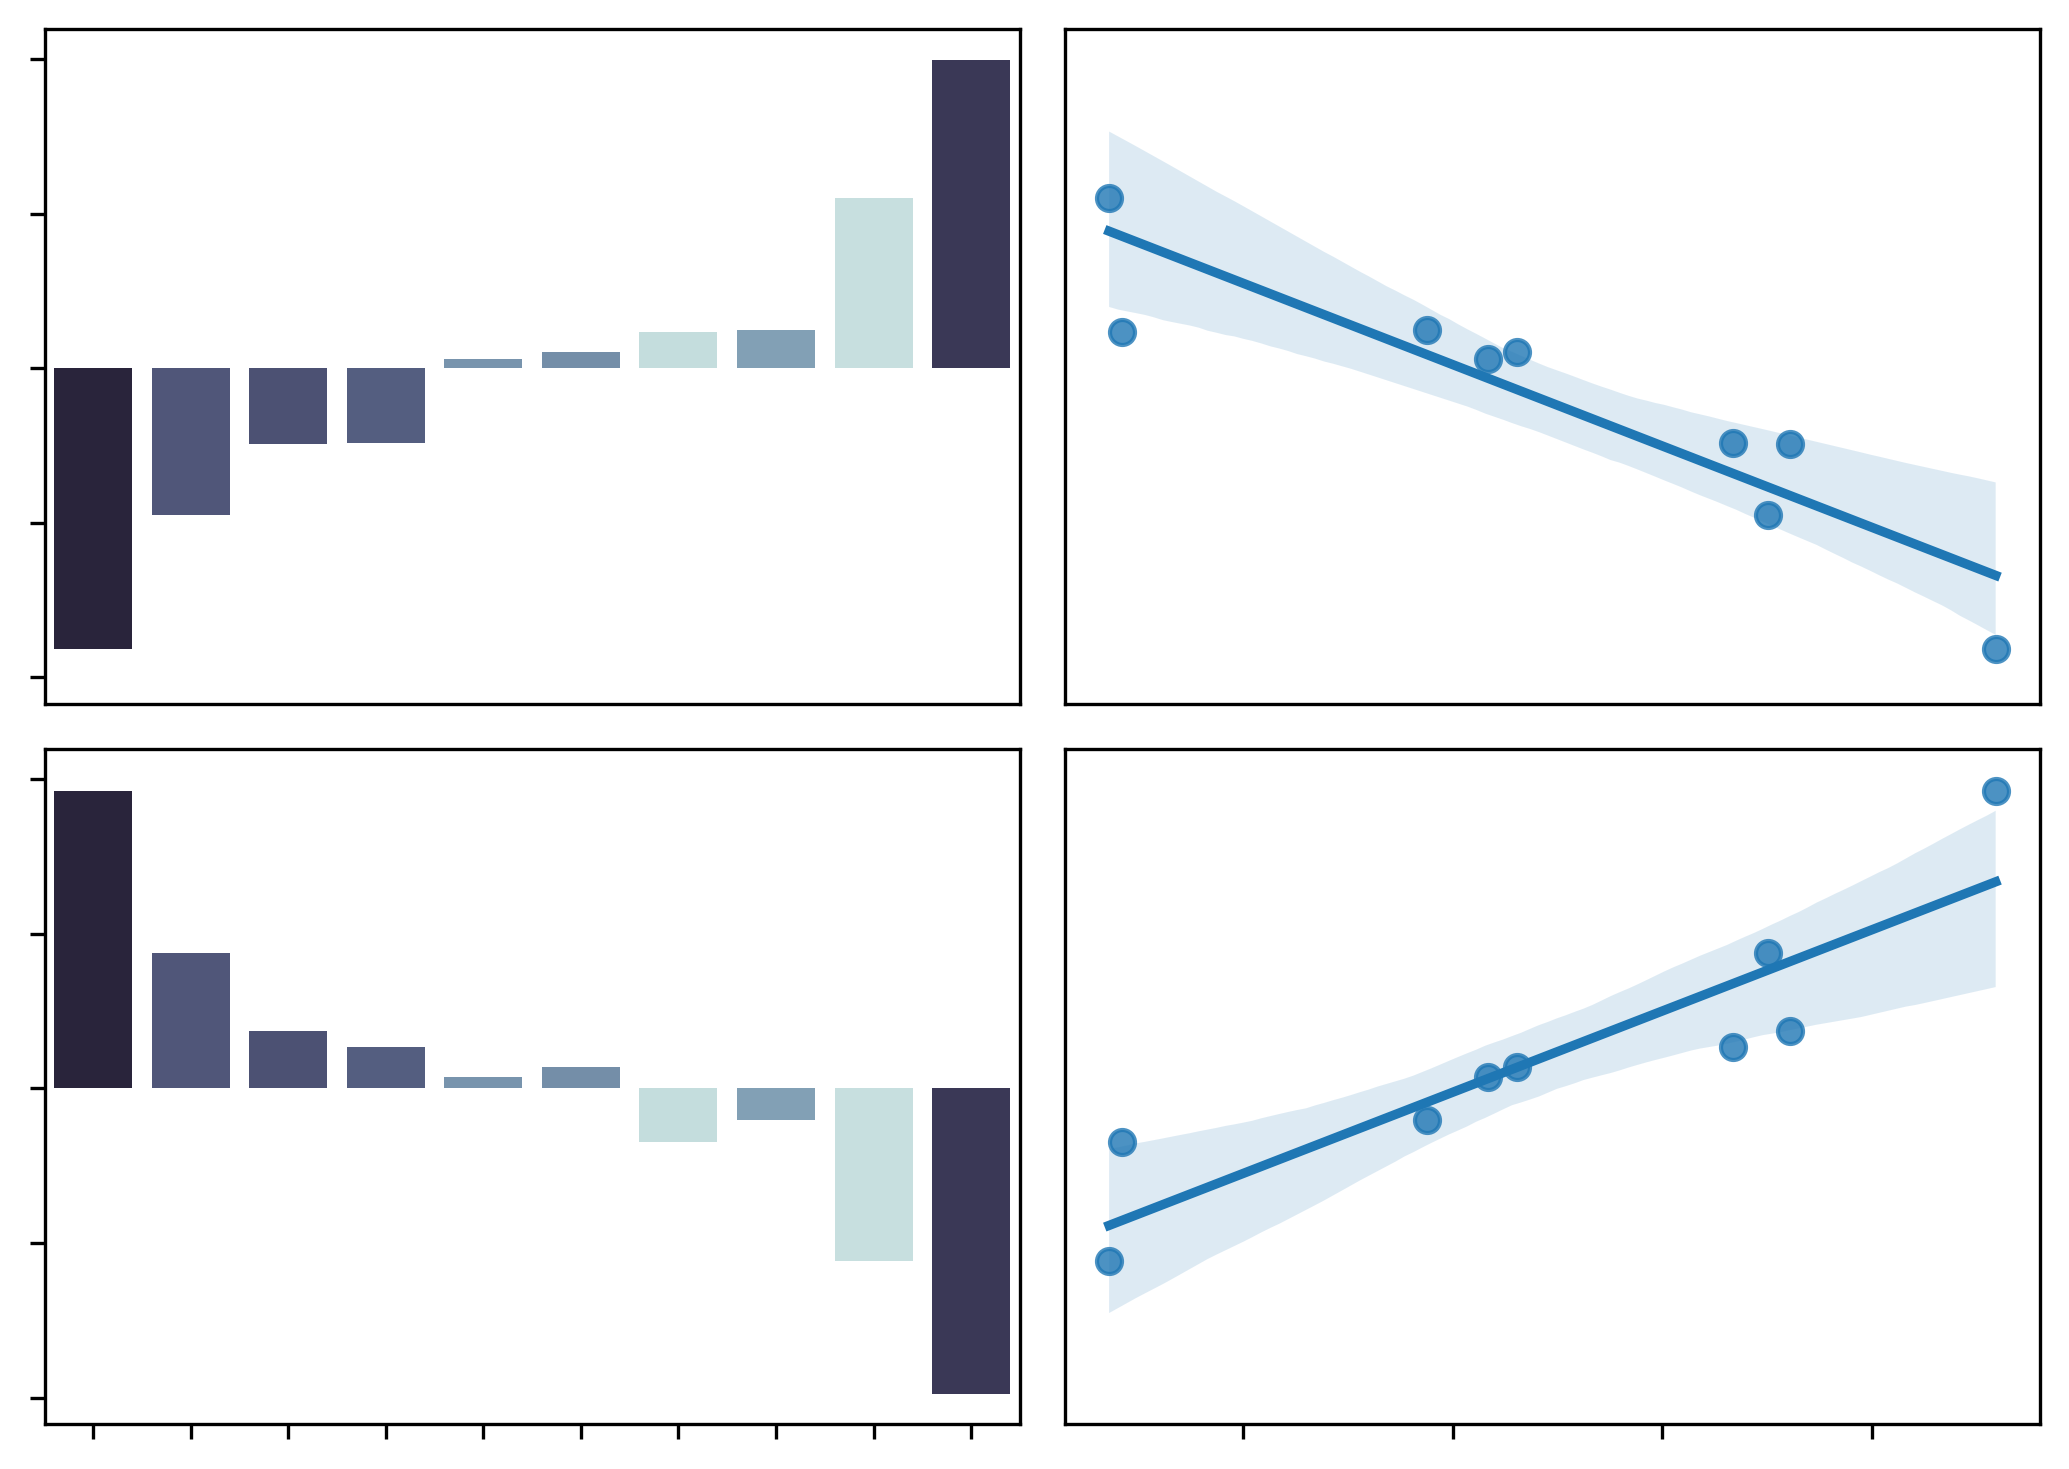

In [336]:
fig, axes = plt.subplots(2, 2, figsize=(7, 5), dpi=300, sharex=False, sharey=True)
ax = sns.barplot(data=MSIintensityICIResponse.sort_values('Scaled_AvgMSLengths'), 
                 x='PatientID', y='Scaled_AvgMSLengths', 
                 hue='TumorRegressionRatio', legend=None, 
                 palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),
                 ax=axes[0, 0])
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, .75))
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.tick_params(bottom=False)

ax = sns.barplot(data=MSIintensityICIResponse.sort_values('Scaled_AvgMSLengths'), 
                 x='PatientID', y='Scaled_StdMSLengths', 
                 hue='TumorRegressionRatio', legend=False, 
                 palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),
                 # palette=sns.cubehelix_palette(as_cmap=True),
                 ax=axes[1, 0])
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, .75), title='Tumor regression ratio', ncol=3, )
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);

ax = sns.regplot(data=MSIintensityICIResponse[(MSIintensityICIResponse['PatientID']!='P18')].sort_values('Scaled_AvgMSLengths'), 
                 x='TumorRegressionRatio', y='Scaled_AvgMSLengths', 
                 # hue='PatientID', 
                 # legend=None, 
                 ax=axes[0, 1])


# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, .75))
ax.set_ylabel('');
ax.set_xlabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.tick_params(bottom=False, left=False)

ax = sns.regplot(data=MSIintensityICIResponse[(MSIintensityICIResponse['PatientID']!='P18')].sort_values('Scaled_AvgMSLengths'), 
                 x='TumorRegressionRatio', y='Scaled_StdMSLengths', 
                 # hue='PatientID', 
                 # legend=None, 
                 ax=axes[1, 1])
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, .75))
ax.set_ylabel('');
ax.set_xlabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.tick_params(bottom=True, left=False)
plt.tight_layout();

plt.tight_layout();

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [279]:
MSIintensityICIResponse

,PatientID,Scaled_AvgMSLengths,Scaled_StdMSLengths,TumorRegressionRatio,Response
0,P04,-1.815772,1.920650,0.9180,CR
6,P15,0.232218,-0.347067,0.0850,PR
8,P17,1.103046,-1.119020,0.0725,PR
5,P19,0.106818,0.137268,0.4619,PR
4,P20,0.056544,0.073384,0.4336,CR
1,P21,-0.949083,0.873591,0.7013,CR
3,P22,-0.483774,0.269873,0.6679,CR
2,P23,-0.491522,0.369965,0.7223,CR
7,P26,0.246371,-0.203855,0.3760,CR


/tmp/ipykernel_117127/3715737015.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=MSIintensityICIResponse, x='Response', y='Scaled_AvgMSLengths', palette=['cornflowerblue', 'goldenrod'], ax=axes[0])
/tmp/ipykernel_117127/3715737015.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=MSIintensityICIResponse, x='Response', y='Scaled_StdMSLengths', palette=['cornflowerblue', 'goldenrod'], ax=axes[1])


<Figure size 600x1200 with 0 Axes>

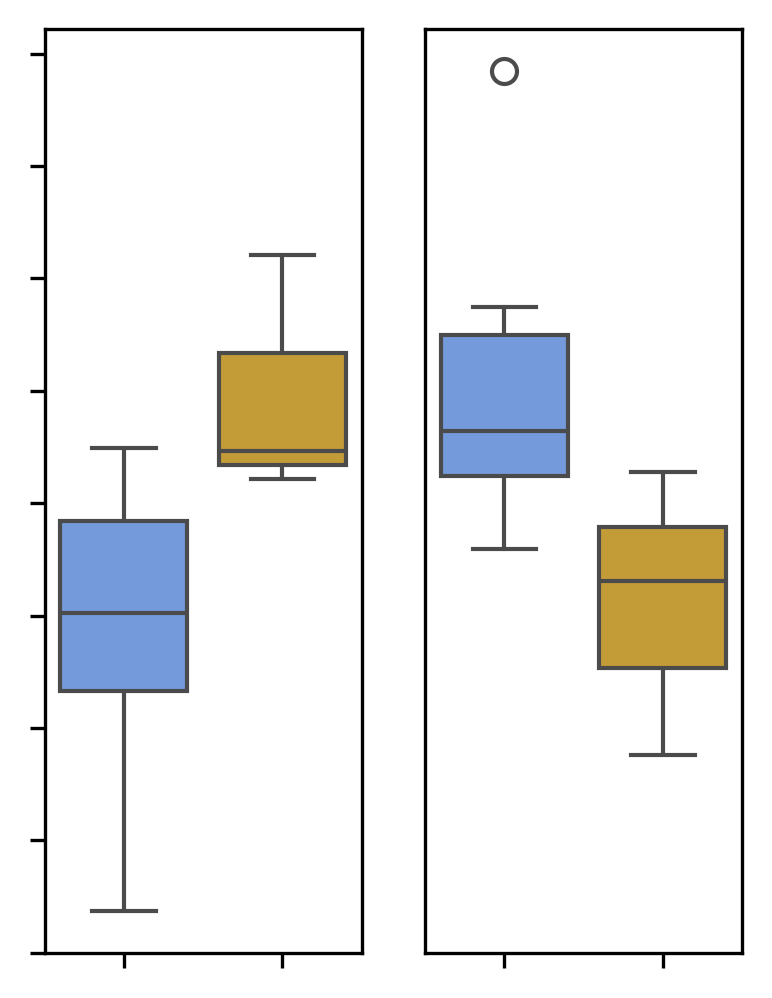

In [307]:
plt.figure(figsize=(2, 4), dpi=300)
fig, axes = plt.subplots(1, 2, figsize=(3, 4), dpi=300, sharey=True, sharex=True)
ax = sns.boxplot(data=MSIintensityICIResponse, x='Response', y='Scaled_AvgMSLengths', palette=['cornflowerblue', 'goldenrod'], ax=axes[0])
ax.set_xlabel('')
ax.set_ylabel('')
# ax.set_xticklabels([]);
# ax.set_yticklabels([]);

ax = sns.boxplot(data=MSIintensityICIResponse, x='Response', y='Scaled_StdMSLengths', palette=['cornflowerblue', 'goldenrod'], ax=axes[1])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.tick_params(left=False,)

AnnData object with n_obs × n_vars = 36023 × 2000
    obs: 'doublet_score', 'predicted_doublet', 'SampleID', 'PatientID', 'BiopsySite', 'Accession', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Response', 'leiden', 'Manual_CellType_lvl_1', 'TumorLocation', 'TumorStage', 'TumorRegressionRatio', 'CancerType', 'Age', 'iCMS3_up', 'iCMS3_dw', 'iCMS2_up', 'iCMS2_dw', 'Scaled_AvgSTRDiff', 'MSIintensity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_varia